In [12]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# -------------------------------
# 0. 데이터 로딩 & 기본 전처리
# -------------------------------
path = '../../preprocessing/log공선성제거_Final_data.csv'

df = pd.read_csv(path)
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# 타깃: 하루 전 대비 변화량 (ret_prev)
df["ret_prev"] = df["y_target_log"] - df["y_target_log"].shift(1)
target_col = "ret_prev"

# y_target_log은 피처에서 제외 (원하면 남겨도 되지만 보통 타깃과 같은 값은 제거)
drop_cols = ["Date", target_col, "y_target_log"]

feature_cols = [c for c in df.columns if c not in drop_cols]

# 숫자형 피처만 사용
X = df[feature_cols].select_dtypes(include=[np.number])
y = df[target_col]

# NaN 제거 (shift 때문에 첫 행 NaN 생김 + 기타 결측)
df_combined = pd.concat([X, y], axis=1).dropna()
X = df_combined.drop(columns=[target_col])
y = df_combined[target_col]

# NaN 제거된 행에 해당하는 날짜
date_all = df.loc[df_combined.index, "Date"].reset_index(drop=True)

print("최종 사용 행 개수:", len(X))
print("사용 피처 수:", X.shape[1])

최종 사용 행 개수: 753
사용 피처 수: 5


Train Val Test 분리 + RMSE, R2, feature_importances 구하기

In [13]:
# -------------------------------
# 1. Train / Valid / Test 분리
# -------------------------------
n = len(X)
test_ratio = 0.2
test_size = int(n * test_ratio)

X_train_all = X.iloc[:-test_size].copy()
y_train_all = y.iloc[:-test_size].copy()

X_test = X.iloc[-test_size:].copy()
y_test = y.iloc[-test_size:].copy()
date_test = date_all.iloc[-test_size:].reset_index(drop=True)

valid_ratio = 0.2
valid_size = int(len(X_train_all) * valid_ratio)

X_train = X_train_all.iloc[:-valid_size].copy()
y_train = y_train_all.iloc[:-valid_size].copy()

X_valid = X_train_all.iloc[-valid_size:].copy()
y_valid = y_train_all.iloc[-valid_size:].copy()

print(f"train={len(X_train)}, valid={len(X_valid)}, test={len(X_test)}")

# -------------------------------
# 2. LightGBM 모델 정의 & 학습
# -------------------------------
lgb_model = lgb.LGBMRegressor(
    objective="regression",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1,
)

# train_all (train+valid)으로 최종 학습
lgb_model.fit(
    X_train_all,
    y_train_all,
    eval_set=[(X_train_all, y_train_all)],
    eval_metric="rmse"
)

# -------------------------------
# 3. Test 성능 평가
# -------------------------------
y_test_pred = lgb_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae  = mean_absolute_error(y_test, y_test_pred)
r2   = r2_score(y_test, y_test_pred)

print("\n=== LightGBM Test 성능 (ret_prev 기준) ===")
print(f"RMSE: {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"R^2 : {r2:.6f}")

# -------------------------------
# 4. 피처 중요도
# -------------------------------
fi = pd.DataFrame({
    "feature": X_train_all.columns,
    "importance": lgb_model.feature_importances_,
}).sort_values("importance", ascending=False)

print("\n[Feature Importance 상위 10개]")
print(fi.head(10))

train=483, valid=120, test=150
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 840
[LightGBM] [Info] Number of data points in the train set: 603, number of used features: 5
[LightGBM] [Info] Start training from score 0.000473
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

차분 안푼 Test 예측 vs 실제값 시각화

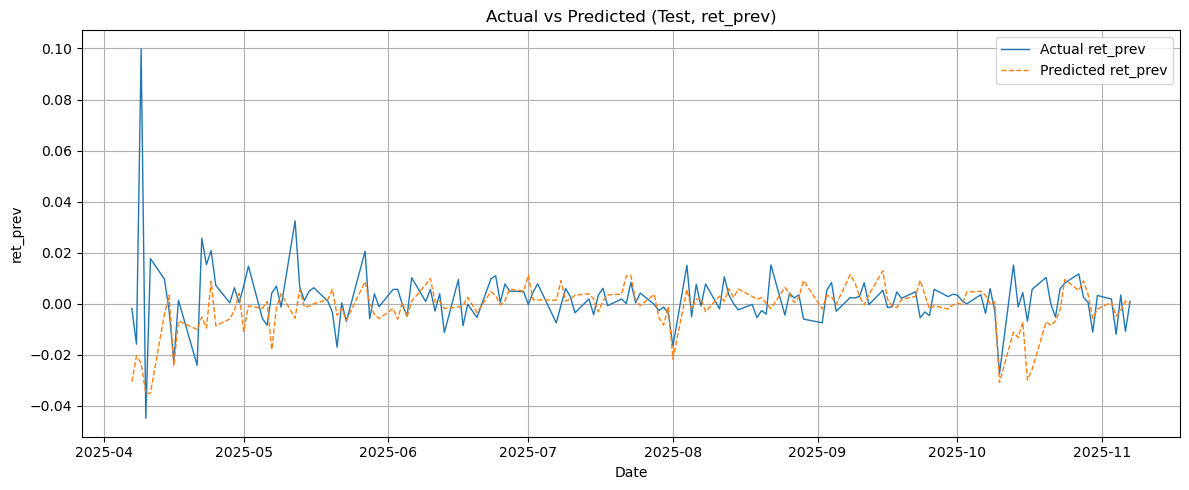

In [14]:
# -------------------------------
# 5. 시각화 - 실제 vs 예측 (Test, ret_prev)
# -------------------------------
plt.figure(figsize=(12, 5))
plt.plot(date_test, y_test.values, label="Actual ret_prev", linewidth=1)
plt.plot(date_test, y_test_pred, label="Predicted ret_prev", linestyle="--", linewidth=1)
plt.title("Actual vs Predicted (Test, ret_prev)")
plt.xlabel("Date")
plt.ylabel("ret_prev")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

차분 푼 Test 예측 vs 실제값 시각화


--- 5. 차분 기반 log level 복원 시작 ---
test_start_idx: 603, n_test: 150

=== 차분 복원 후 '로그 레벨 기준' Test 성능 ===
RMSE (log): 0.014546
MAE  (log): 0.008203
R^2  (log): 0.961080

--- 복원된 로그 레벨 결과 (앞 5개) ---
        Date  log_true_df  log_pred
0 2025-04-07     6.223330  6.194589
1 2025-04-08     6.207543  6.202901
2 2025-04-09     6.307406  6.184249
3 2025-04-10     6.262598  6.272168
4 2025-04-11     6.280283  6.227701


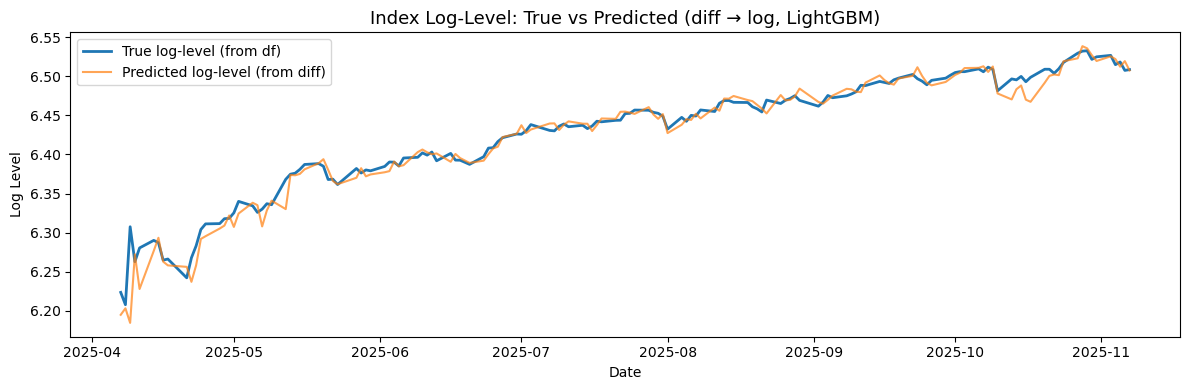

In [15]:
# =======================================================================
# 5. 차분 → log level 복원 (exp 안 쓰고 로그레벨까지만)
#    - ret_prev = y_target_log[t] - y_target_log[t-1]
#    - log_pred[t] = log_prev[t] + ret_prev_pred[t]
# =======================================================================

print("\n--- 5. 차분 기반 log level 복원 시작 ---")

date_col  = "Date"
price_col = "y_target_log"   # 로그 지수 컬럼

# 1) df_combined에 맞춘 로그 레벨 전체 시계열
#    (NaN 제거된 행 기준으로 정렬된 상태)
y_log_all = df.loc[df_combined.index, price_col].reset_index(drop=True)

# 2) test 시작 인덱스 & 길이
#    - X_train_all: 앞쪽 (train+valid)
#    - X_test: 뒤쪽 test 부분
test_start_idx = len(X_train_all)      # df_combined 기준에서 test의 첫 위치
n_test         = len(y_test_pred)      # test 길이

print(f"test_start_idx: {test_start_idx}, n_test: {n_test}")

# 3) test 구간에서 "어제 로그 지수" log P_{t-1}
log_prev = (
    y_log_all
    .iloc[test_start_idx - 1 : test_start_idx - 1 + n_test]
    .reset_index(drop=True)
    .to_numpy()
)  # shape: (n_test,)

# 4) test 구간에서 "오늘 로그 지수" 진짜 값 (df 기준 ground truth)
log_true_df = (
    y_log_all
    .iloc[test_start_idx : test_start_idx + n_test]
    .reset_index(drop=True)
    .to_numpy()
)  # shape: (n_test,)

# 5) 차분(ret_prev) 예측값으로부터 로그 지수 복원
#    logP_hat[t] = logP_true[t-1] + ret_prev_pred[t]
ret_pred = y_test_pred.reshape(-1)   # (n_test,)

log_pred_from_diff = log_prev + ret_pred   # 예측 로그 레벨

# 6) 로그 레벨 기준 성능 평가
rmse_log = np.sqrt(mean_squared_error(log_true_df, log_pred_from_diff))
mae_log  = mean_absolute_error(log_true_df, log_pred_from_diff)
r2_log   = r2_score(log_true_df, log_pred_from_diff)

print("\n=== 차분 복원 후 '로그 레벨 기준' Test 성능 ===")
print(f"RMSE (log): {rmse_log:.6f}")
print(f"MAE  (log): {mae_log:.6f}")
print(f"R^2  (log): {r2_log:.6f}")
print("============================================")

# 7) 결과 DataFrame + 시각화 (로그 레벨)
date_test_for_log = (
    date_all
    .iloc[test_start_idx : test_start_idx + n_test]
    .reset_index(drop=True)
)

result_log = pd.DataFrame({
    "Date": date_test_for_log,
    "log_true_df":  log_true_df,         # df에서 직접 가져온 log 지수
    "log_pred":     log_pred_from_diff,  # ret_prev 예측값으로 복원한 log 지수
})

print("\n--- 복원된 로그 레벨 결과 (앞 5개) ---")
print(result_log.head())

plt.figure(figsize=(12, 4))
plt.plot(result_log["Date"], result_log["log_true_df"],
         label="True log-level (from df)", linewidth=2)
plt.plot(result_log["Date"], result_log["log_pred"],
         label="Predicted log-level (from diff)", alpha=0.7)
plt.title("Index Log-Level: True vs Predicted (diff → log, LightGBM)", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Log Level")
plt.legend()
plt.tight_layout()
plt.show()


차분 안푼 잔차 그래프


--- 6. 잔차 분포 시각화 시작 (Test Set) ---


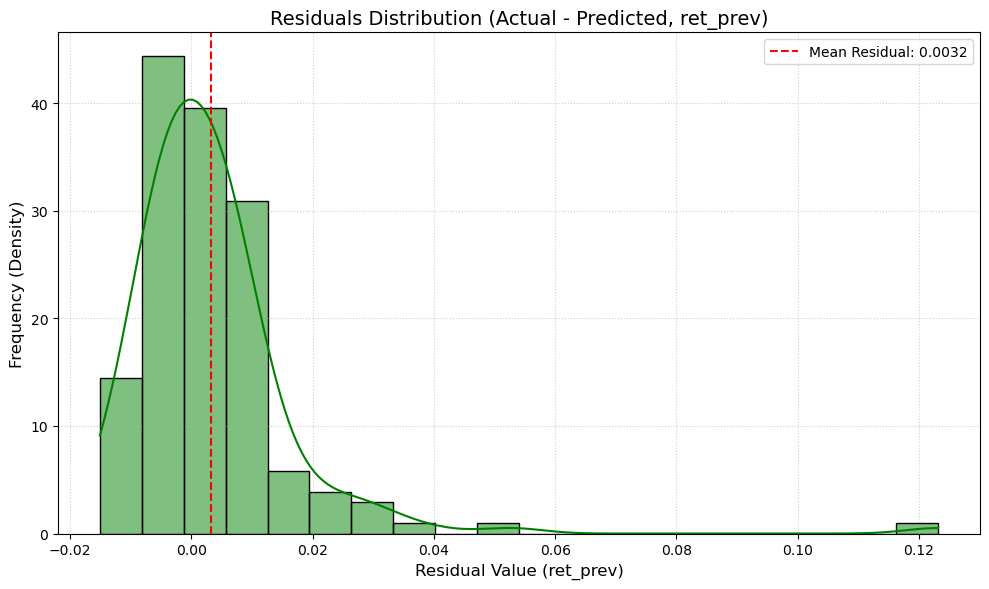

In [16]:
# 필요한 라이브러리가 모두 import되었다고 가정합니다.
# (pandas, numpy, matplotlib.pyplot, seaborn)
import seaborn as sns
# ----------------------------------------------------
# 6. 잔차(Residuals) 분포 시각화 (Test Set 기준)
# ----------------------------------------------------
print("\n--- 6. 잔차 분포 시각화 시작 (Test Set) ---")

# 1. 잔차 계산: Residual = Actual - Predicted
residuals_test = y_test - y_test_pred

# 2. 평균 잔차 계산
mean_residual = residuals_test.mean()

# 3. 잔차 분포 시각화 (Seaborn distplot 또는 histplot 사용)
plt.figure(figsize=(10, 6))

# 히스토그램과 커널 밀도 추정(KDE) 곡선 그리기
sns.histplot(
    residuals_test,
    bins=20,  # 히스토그램 막대 개수
    kde=True, # KDE 곡선 추가
    color='green',
    edgecolor='black',
    alpha=0.5,
    stat="density" # Y축을 밀도로 표시
)

# 평균 잔차를 나타내는 수직선 추가
plt.axvline(
    mean_residual,
    color='red',
    linestyle='--',
    label=f'Mean Residual: {mean_residual:.4f}'
)

# 그래프 설정
plt.title(f'Residuals Distribution (Actual - Predicted, {target_col})', fontsize=14)
plt.xlabel(f'Residual Value ({target_col})', fontsize=12)
plt.ylabel('Frequency (Density)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()


차분 푼 잔차 그래프


--- 6. 잔차 분포 시각화 시작 (복원 Log Level) ---


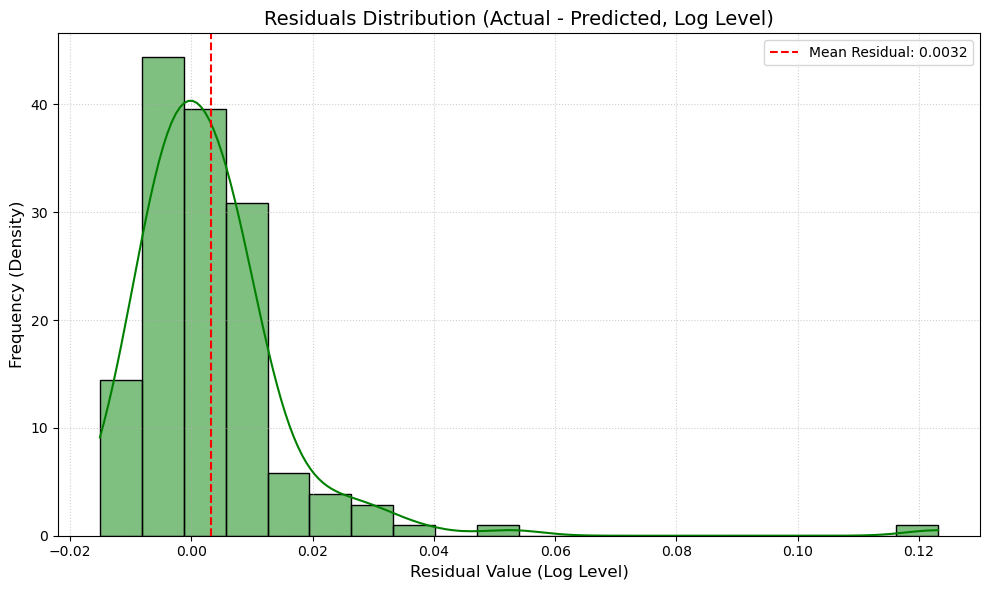

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ----------------------------------------------------
# 6. 잔차(Residuals) 분포 시각화 (복원된 Log Level 기준)
# ----------------------------------------------------
print("\n--- 6. 잔차 분포 시각화 시작 (복원 Log Level) ---")

# 1. 잔차 계산: Residual = Actual_Level - Pred_Level
# (이전 코드에서 생성된 'result_log' DataFrame 사용)
# result_log의 컬럼명: "log_true_df", "log_pred"
residuals_level = result_log["log_true_df"].values - result_log["log_pred"].values

# 2. 평균 잔차 계산
mean_residual_level = residuals_level.mean()

# 3. 잔차 분포 시각화 (Seaborn histplot 사용)
plt.figure(figsize=(10, 6))

sns.histplot(
    residuals_level,
    bins=20,
    kde=True,
    color='green', 
    edgecolor='black',
    alpha=0.5,
    stat="density"
)

# 평균 잔차를 나타내는 수직선 추가
plt.axvline(
    mean_residual_level,
    color='red',
    linestyle='--',
    label=f'Mean Residual: {mean_residual_level:.4f}'
)

# 그래프 설정
plt.title(f'Residuals Distribution (Actual - Predicted, Log Level)', fontsize=14)
plt.xlabel(f'Residual Value (Log Level)', fontsize=12) 
plt.ylabel('Frequency (Density)', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

최적 seq_len 찾고 모델 돌리기

In [18]:
# ============================================================
# 6. seq_len = 1~50 슬라이딩 윈도우 + LightGBM 성능 비교
#      - 과거 seq_len 길이만큼 피처를 이어붙여 하나의 벡터로 사용
#      - Validation RMSE가 가장 좋은 seq_len 선택
# ============================================================

def make_seq_dataset_for_reg(X_df, y_series, seq_len):
    """
    X_df    : (N, num_features) DataFrame
    y_series: (N,) Series
    반환:
      X_seq: (num_samples, seq_len, num_features)
      y_seq: (num_samples,)
    타깃은 윈도우 마지막 시점의 y
    """
    X_array = X_df.to_numpy()
    y_array = y_series.to_numpy()

    X_list = []
    y_list = []
    for i in range(len(X_array) - seq_len + 1):
        X_list.append(X_array[i : i + seq_len])
        y_list.append(y_array[i + seq_len - 1])

    return np.array(X_list), np.array(y_list)


candidate_seq_lens = list(range(1, 51))  # 1 ~ 50
best_seq_len  = None
best_val_rmse = np.inf

best_model_seq = None
best_X_test_seq = None
best_y_test_seq = None

print("\n================ seq_len 탐색 (LightGBM) ================")

for seq_len in candidate_seq_lens:
    # 1) 시퀀스 데이터 생성 (전체 X, y 기준)
    X_seq, y_seq = make_seq_dataset_for_reg(X, y, seq_len)
    n_samples = len(X_seq)

    if n_samples < 50:
        print(f"seq_len={seq_len} → 샘플 수 부족 (n={n_samples}), 스킵")
        continue

    # 2) Train / Valid / Test 분할
    #    - test: 20% (맨 뒤)
    #    - 남은 80% 중 valid: 20% (전체의 16%), train: 나머지(64%)
    test_ratio  = 0.2
    valid_ratio = 0.2

    test_size  = int(n_samples * test_ratio)
    remaining  = n_samples - test_size
    valid_size = int(remaining * valid_ratio)
    train_size = remaining - valid_size

    train_end = train_size
    valid_end = train_size + valid_size

    print(f"\n[seq_len={seq_len}] 분할 결과")
    print(f"Total: {n_samples}")
    print(f"Train: {train_size} ({train_size/n_samples:.2%})")
    print(f"Valid: {valid_size} ({valid_size/n_samples:.2%})")
    print(f"Test : {test_size}  ({test_size/n_samples:.2%})")

    # 3D (samples, seq_len, features) → 2D (samples, seq_len*features)
    X_train_seq = X_seq[:train_end].reshape(train_size, -1)
    y_train_seq = y_seq[:train_end]

    X_valid_seq = X_seq[train_end:valid_end].reshape(valid_size, -1)
    y_valid_seq = y_seq[train_end:valid_end]

    X_test_seq  = X_seq[valid_end:].reshape(test_size, -1)
    y_test_seq  = y_seq[valid_end:]

    # 3) LightGBM 모델 정의 (위와 동일한 하이퍼파라미터 사용)
    lgb_model_seq = lgb.LGBMRegressor(
        objective="regression",
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.0,
        reg_lambda=1.0,
        random_state=42,
        n_jobs=-1,
    )

    # Train (valid은 성능 평가용)
    lgb_model_seq.fit(
        X_train_seq,
        y_train_seq,
        eval_set=[(X_valid_seq, y_valid_seq)],
        eval_metric="rmse",
        # verbose=False
    )

    # 4) Validation 성능 계산
    y_valid_pred_seq = lgb_model_seq.predict(X_valid_seq)
    val_rmse_seq = np.sqrt(mean_squared_error(y_valid_seq, y_valid_pred_seq))

    print(f"→ Validation RMSE: {val_rmse_seq:.6f}")

    # 5) 최적 seq_len 갱신
    if val_rmse_seq < best_val_rmse:
        best_val_rmse = val_rmse_seq
        best_seq_len  = seq_len
        best_model_seq = lgb_model_seq
        best_X_test_seq = X_test_seq
        best_y_test_seq = y_test_seq

# ---------------- 최종 결과 정리 ----------------
print("\n================ 최종 seq_len 결과 =================")
print(f"최적 seq_len: {best_seq_len}")
print(f"최적 Validation RMSE: {best_val_rmse:.6f}")

# 선택된 seq_len 기준 Test 성능
if best_model_seq is not None:
    y_test_pred_best = best_model_seq.predict(best_X_test_seq)
    best_test_rmse = np.sqrt(mean_squared_error(best_y_test_seq, y_test_pred_best))
    best_test_mae  = mean_absolute_error(best_y_test_seq, y_test_pred_best)
    best_test_r2   = r2_score(best_y_test_seq, y_test_pred_best)

    print(f"\n[최적 seq_len 기준 Test 성능]")
    print(f"RMSE: {best_test_rmse:.6f}")
    print(f"MAE : {best_test_mae:.6f}")
    print(f"R^2 : {best_test_r2:.6f}")
else:
    print("유효한 seq_len으로 학습된 모델이 없습니다.")



================ seq_len 탐색 (LightGBM) ================

[seq_len=1] 분할 결과
Total: 753
Train: 483 (64.14%)
Valid: 120 (15.94%)
Test : 150  (19.92%)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 483, number of used features: 5
[LightGBM] [Info] Start training from score 0.000862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


→ Validation RMSE: 0.011529

[seq_len=10] 분할 결과
Total: 744
Train: 477 (64.11%)
Valid: 119 (15.99%)
Test : 148  (19.89%)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6706
[LightGBM] [Info] Number of data points in the train set: 477, number of used features: 50
[LightGBM] [Info] Start training from score 0.000799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17074
[LightGBM] [Info] Number of data points in the train set: 467, number of used features: 130
[LightGBM] [Info] Start training from score 0.000778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


→ Validation RMSE: 0.015266

[seq_len=31] 분할 결과
Total: 723
Train: 464 (64.18%)
Valid: 115 (15.91%)
Test : 144  (19.92%)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 20230
[LightGBM] [Info] Number of data points in the train set: 464, number of used features: 155
[LightGBM] [Info] Start training from score 0.000905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


→ Validation RMSE: 0.015236

[seq_len=34] 분할 결과
Total: 720
Train: 461 (64.03%)
Valid: 115 (15.97%)
Test : 144  (20.00%)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22048
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 170
[LightGBM] [Info] Start training from score 0.000897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


→ Validation RMSE: 0.015034

[seq_len=37] 분할 결과
Total: 717
Train: 460 (64.16%)
Valid: 114 (15.90%)
Test : 143  (19.94%)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23966
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 185
[LightGBM] [Info] Start training from score 0.000906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25766
[LightGBM] [Info] Number of data points in the train set: 458, number of used features: 200
[LightGBM] [Info] Start training from score 0.000902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


→ Validation RMSE: 0.015525

[seq_len=49] 분할 결과
Total: 705
Train: 452 (64.11%)
Valid: 112 (15.89%)
Test : 141  (20.00%)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 31160
[LightGBM] [Info] Number of data points in the train set: 452, number of used features: 245
[LightGBM] [Info] Start training from score 0.000830
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\ssginc07\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


최적 seq_len 차분 풀기

In [19]:
# =======================================================================
# seq_len 최적 모델 기준 차분 → log level 복원
# =======================================================================

print("\n--- seq_len 기반 차분 → 로그 레벨 복원 시작 ---")

price_col = "y_target_log"

# df_combined와 동일한 인덱스를 갖는 로그 레벨
y_log_all = df.loc[df_combined.index, price_col].reset_index(drop=True)

if best_model_seq is None:
    print("best_model_seq 없음 → seq_len 복원 불가")
else:
    # -------------------------------------------
    # 1) 전체 데이터에서 seq_len 적용한 시퀀스 다시 생성
    #    → orig_pos_test 를 구하기 위함
    # -------------------------------------------
    X_seq, y_seq = make_seq_dataset_for_reg(X, y, best_seq_len)
    n_samples = len(X_seq)

    test_ratio  = 0.2
    valid_ratio = 0.2

    test_size  = int(n_samples * test_ratio)
    remaining  = n_samples - test_size
    valid_size = int(remaining * valid_ratio)
    train_size = remaining - valid_size

    train_end = train_size
    valid_end = train_size + valid_size

    print(f"[seq_len={best_seq_len}] seq 전체 개수={n_samples}, test={test_size}")

    # -------------------------------------------
    # 2) Test 시퀀스(윈도우)의 타깃이 df_combined 상에서 가리키는 실제 시점
    #    → 시퀀스 s 의 타깃은 (s + seq_len - 1)
    # -------------------------------------------
    test_seq_idx = np.arange(valid_end, n_samples)            # 길이 = test_size
    orig_pos_test = test_seq_idx + best_seq_len - 1           # df_combined 기준 index

    # -------------------------------------------
    # 3) log level ground truth & "직전 log level" 추출
    # -------------------------------------------
    log_true_seq = y_log_all.iloc[orig_pos_test].to_numpy()         # logP[t]
    log_prev_seq = y_log_all.iloc[orig_pos_test - 1].to_numpy()     # logP[t-1]

    # -------------------------------------------
    # 4) seq_len 모델의 ret_prev 예측값으로 log 레벨 복원
    #    logP_pred[t] = logP[t-1] + ret_prev_pred[t]
    # -------------------------------------------
    ret_pred_seq = y_test_pred_best.reshape(-1)    # (test_size,)
    log_pred_seq = log_prev_seq + ret_pred_seq

    # -------------------------------------------
    # 5) 로그 레벨 기준 성능 계산
    # -------------------------------------------
    rmse_seq_log = np.sqrt(mean_squared_error(log_true_seq, log_pred_seq))
    mae_seq_log  = mean_absolute_error(log_true_seq, log_pred_seq)
    r2_seq_log   = r2_score(log_true_seq, log_pred_seq)

    print("\n=== seq_len 기반 로그 레벨 복원 Test 성능 ===")
    print(f"best_seq_len : {best_seq_len}")
    print(f"RMSE (log)   : {rmse_seq_log:.6f}")
    print(f"R^2  (log)   : {r2_seq_log:.6f}")
    print("====================================================")

    # -------------------------------------------
    # 6) DataFrame 구성 (시각화용)
    # -------------------------------------------
    date_seq_test = date_all.iloc[orig_pos_test].reset_index(drop=True)

    result_seq_log = pd.DataFrame({
        "Date": date_seq_test,
        "log_true": log_true_seq,
        "log_pred": log_pred_seq
    }).set_index("Date")

    print("\n--- seq_len 기반 log-level 복원 결과 (앞 5개) ---")
    print(result_seq_log.head())



--- seq_len 기반 차분 → 로그 레벨 복원 시작 ---
[seq_len=2] seq 전체 개수=752, test=150

=== seq_len 기반 로그 레벨 복원 Test 성능 ===
best_seq_len : 2
RMSE (log)   : 0.013387
R^2  (log)   : 0.967035

--- seq_len 기반 log-level 복원 결과 (앞 5개) ---
            log_true  log_pred
Date                          
2025-04-07  6.223330  6.211189
2025-04-08  6.207543  6.212321
2025-04-09  6.307406  6.195707
2025-04-10  6.262598  6.305564
2025-04-11  6.280283  6.249648


최적 seq_len test부분 시각화

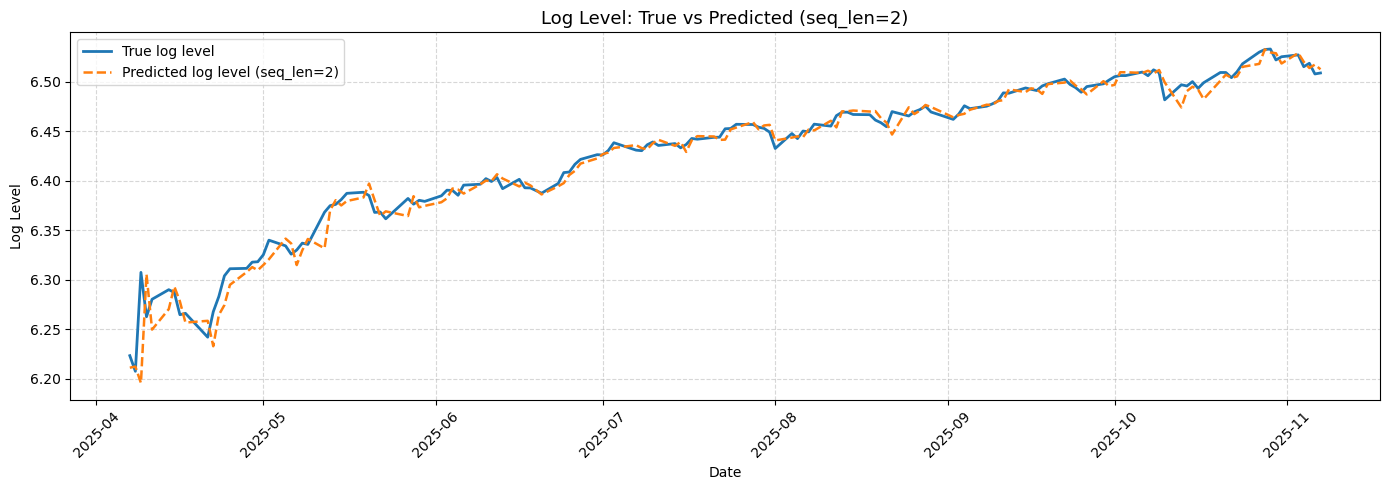

In [20]:
# =======================================================================
# 7) seq_len 기반 log-level 복원 결과 시각화
# =======================================================================

# 1) 시계열 플롯: 실제 vs 예측 (log level)
plt.figure(figsize=(14, 5))
plt.plot(
    result_seq_log.index,
    result_seq_log["log_true"],
    label="True log level",
    linewidth=2
)
plt.plot(
    result_seq_log.index,
    result_seq_log["log_pred"],
    label=f"Predicted log level (seq_len={best_seq_len})",
    linestyle="--",
    linewidth=1.8
)
plt.title(f"Log Level: True vs Predicted (seq_len={best_seq_len})", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Log Level")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

seq_len 결과 저장

In [21]:
# =======================================================================
# seq_len 복원 성능 → CSV 저장 (컬럼명 커스텀)
# =======================================================================

save_path_seq_metrics = "../../modeling/성능지표/SPY_LightGBM_지표.csv"

metrics_for_save = pd.DataFrame({
    "SPY_LightGBM_RMSE": [rmse_seq_log],   # 로그 기준 RMSE
    "SPY_LightGBM_R2":   [r2_seq_log],     # 로그 기준 R²
})

metrics_for_save.to_csv(save_path_seq_metrics, index=False, encoding="utf-8-sig")

print("\nCSV 저장 완료:", save_path_seq_metrics)
print(metrics_for_save)



CSV 저장 완료: ../../modeling/성능지표/SPY_LightGBM_지표.csv
   SPY_LightGBM_RMSE  SPY_LightGBM_R2
0           0.013387         0.967035


In [22]:
import joblib
import os

# ----------------------------------------------------
# 1. LightGBM 모델 저장 (최적 seq_len 기반)
# ----------------------------------------------------

# (가정: best_seq_len 및 best_model_seq 변수가 이전에 정의되었다고 가정)

# 저장할 디렉토리와 파일명 설정
model_dir = "../../modeling/Model/"
# 파일명에 모델 종류(lgbm)와 최적 seq_len을 포함시켜 구별합니다.
model_filename = f"LightGBM_best.joblib"
model_path = os.path.join(model_dir, model_filename)

# 모델 디렉토리가 없다면 생성
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 모델 저장
# LightGBM 모델 객체가 best_model_seq에 저장되어 있다고 가정
try:
    joblib.dump(best_model_seq, model_path)
    
    print(f"\n최종 LightGBM 모델이 성공적으로 저장되었습니다.")
    print(f"   경로: {model_path}")

except NameError:
    print("\n모델 저장 실패: 'best_model_seq' 또는 'best_seq_len' 변수가 정의되지 않았습니다.")
except Exception as e:
    print(f"\n모델 저장 중 오류 발생: {e}")


최종 LightGBM 모델이 성공적으로 저장되었습니다.
   경로: ../../modeling/Model/LightGBM_best.joblib
